# AI application for image classification. (flowers species)


   Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications

**In this project, we will train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at.**

**We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.**

<img src='assets/Flowers.png' width=500px>

#### The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content


## Importing the required packages through the project

In [1]:
# Importing the required packages 
import torch
from torch import nn, optim
from torch.nn import Sequential
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [2]:
# Define a device to run the code in GPU if it is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Load the data

Here we will use `torchvision` to load the data. The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We will also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this it doesn't need any scaling or rotation transformations, but we will need to resize then crop the images to the appropriate size.

The pre-trained networks we will use- were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
# Defining the data directories

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# Defining a normalizer for the image color channels

normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Defining transformers for the training set.
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalizer])

# Defining transformers for the validation and test sets.
test_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       normalizer])
    

# Loading the training set with ImageFolder
train_set = datasets.ImageFolder(train_dir, transform=train_transforms) 

# Loading the validation set with ImageFolder
valid_set = datasets.ImageFolder(valid_dir, transform=test_transforms) 

# Loading the test set with ImageFolder
test_set = datasets.ImageFolder(test_dir, transform=test_transforms) 

# Defining DataLoaders

# training dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# validation dataloader
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64)

# training dataloader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we will use one of the pretrained models from `torchvision.models` to get the image features. 

We will build and train a new feed-forward classifier using those features.

**So, here we will**
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (We will use vgg16 model).
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters
* Save the trained model to use later for more training or predection.

**While running the model training code, to keep the session workspace active, we will include code from the `workspace_utils.py` module (We will use `active_session` module.**


## Loading the pretrained (vgg16) model

In [7]:
model = models.vgg16(pretrained=True)
# the model calssifier arch
model.classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 57986762.39it/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
# freezing the features parameters
for param in model.parameters():
    param.requires_grad = False
    
# defining classifier parameters to fit
# the 102 categories for our classifier output
    
model.classifier = nn.Sequential(nn.Linear(25088,4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(4096, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 102),
                                 nn.LogSoftmax(dim=1))
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=512, out_features=102, bias=True)
  (7): LogSoftmax()
)

## Model training function

In [15]:
def train_model(model, arch, device=device,  lr=0.001, epochs=1):
    """
    a function that trained the choosen pretrained model
    on the data in the provided directory. The training uses
    NLLLoss - as criterion - and Adam optimizer.
    The code runs in CPU or GPU according to the device arg.
    
    args:
        data_dir (str): the directory of the data
        model (str): the pretrained model used in training
        device (str): the device in which the code runs [cpu or gpu]
        arch (str): the model architecture
        lr (float): the learning rate used in the model optimizer
        epochs (int): the number of epochs used in model training  
        
    returns:
        None: it trains the model only
    """
    
    # moving the model to the device
    model = model.to(device)
    
    # defining our criterion as NLLLoss 
    criterion = nn.NLLLoss()
    
    # using Adam optemizer to train the..
    # model calssifier parameters
    if arch == 'vgg16':
        classifier = model.classifier
    elif arch == 'resnet152':
        classifier = model.fc
    
    optimizer = optim.Adam(classifier.parameters(), lr)
    
    # we save mapping of classes to indices from an image set
    model.class_to_idx = train_set.class_to_idx
    
    # setting up the active session mode
    # to avoid workspace shutdown during model training
    # as the training can take a lot of time
    from workspace_utils import active_session

    with active_session():

        for e in range(epochs):
            
            step = 0
            train_loss = 0

            # iterating across train_loader
            for images, labels in train_loader:
                step += 1
                # moving images and labels to the device mode
                images, labels = images.to(device), labels.to(device)
            
                optimizer.zero_grad()
                log_probs = model(images)
                loss = criterion(log_probs, labels)
                loss.backward()
                optimizer.step()
            
                train_loss += loss.item()
                #if step % 10 == 0:
                    #print(f"epoch: {e+1}  {step} steps...")
            # -------------------------
            # iterating across the valid set to calculate Loss and accuracy
            
            valid_loss = 0
            accuracy = 0
            
            # turning off the auto grad feature to fasten the code
            # and moving to evaluating mode
            with torch.no_grad():
                model.eval()
                for images, labels in valid_loader:
                    # moving images and labels to the device mode
                    images, labels = images.to(device), labels.to(device)
                    
                    log_probs = model(images)
                    valid_loss += criterion(log_probs, labels)
                    probs = torch.exp(log_probs)
                    
                    # finding the top class in each of the probs
                    top_prob, top_class = probs.topk(1, dim=1)

                    # matches between top_class and labels
                    matches = top_class == labels.view(top_class.shape)
                    
                    accuracy += torch.mean(matches.type(torch.FloatTensor))

                print(f"in epoch {e+1} after {step} steps train_loss = {train_loss/len(train_loader):.3f},  "
                      f"valid_loss = {valid_loss/len(valid_loader):.3f}  "
                      f"valid accuracy = {accuracy/len(valid_loader):.3f}")
                    
            # moving to training mode
            model.train()
            train_loss = 0
            accuracy_train = 0

   

## Training the model

In [12]:
train_model(model, arch='vgg16', device=device,  lr=0.001, epochs=1)

epoch: 1  10 steps...
epoch: 1  20 steps...
epoch: 1  30 steps...
epoch: 1  40 steps...
epoch: 1  50 steps...
epoch: 1  60 steps...
epoch: 1  70 steps...
epoch: 1  80 steps...
epoch: 1  90 steps...
epoch: 1  100 steps...
in epoch 1 after 103 steps train_loss = 2.136,  valid_loss = 0.874  valid accuracy = 0.756


In [16]:
train_model(model, arch='vgg16', device=device,  lr=0.001, epochs=10)

in epoch 1 after 103 steps train_loss = 1.116,  valid_loss = 0.653  valid accuracy = 0.808
in epoch 2 after 103 steps train_loss = 0.966,  valid_loss = 0.542  valid accuracy = 0.855
in epoch 3 after 103 steps train_loss = 0.893,  valid_loss = 0.458  valid accuracy = 0.881
in epoch 4 after 103 steps train_loss = 0.844,  valid_loss = 0.497  valid accuracy = 0.866
in epoch 5 after 103 steps train_loss = 0.799,  valid_loss = 0.507  valid accuracy = 0.883
in epoch 6 after 103 steps train_loss = 0.741,  valid_loss = 0.407  valid accuracy = 0.888
in epoch 7 after 103 steps train_loss = 0.735,  valid_loss = 0.396  valid accuracy = 0.900
in epoch 8 after 103 steps train_loss = 0.714,  valid_loss = 0.429  valid accuracy = 0.895
in epoch 9 after 103 steps train_loss = 0.662,  valid_loss = 0.346  valid accuracy = 0.920
in epoch 10 after 103 steps train_loss = 0.701,  valid_loss = 0.341  valid accuracy = 0.917


In [17]:
train_model(model, arch='vgg16', device=device,  lr=0.001, epochs=10)

in epoch 1 after 103 steps train_loss = 0.721,  valid_loss = 0.480  valid accuracy = 0.905
in epoch 2 after 103 steps train_loss = 0.701,  valid_loss = 0.453  valid accuracy = 0.905
in epoch 3 after 103 steps train_loss = 0.692,  valid_loss = 0.433  valid accuracy = 0.909
in epoch 4 after 103 steps train_loss = 0.674,  valid_loss = 0.374  valid accuracy = 0.932
in epoch 5 after 103 steps train_loss = 0.635,  valid_loss = 0.425  valid accuracy = 0.902
in epoch 6 after 103 steps train_loss = 0.628,  valid_loss = 0.412  valid accuracy = 0.920
in epoch 7 after 103 steps train_loss = 0.684,  valid_loss = 0.436  valid accuracy = 0.912
in epoch 8 after 103 steps train_loss = 0.649,  valid_loss = 0.399  valid accuracy = 0.916
in epoch 9 after 103 steps train_loss = 0.681,  valid_loss = 0.448  valid accuracy = 0.905
in epoch 10 after 103 steps train_loss = 0.649,  valid_loss = 0.363  valid accuracy = 0.920


## Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. 

This will give a good estimate for the model's performance on completely new images.

In [20]:
# calculating accuracy in predecting the test set
def test_data(test_loader = test_loader):
    """
    a function that calculates the model accuracy
    in predicting data.
    args:
        test_loader: a data loader having the testing data
        
    returns: 
        accuracy (float): the value of the accuracy
    """

    accuracy = 0
    # turning off the auto grad feature to fasten the code
    # and moving to evaluating mode
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            # moving images and labels to the device mode
            images, labels = images.to(device), labels.to(device)
                            
            log_probs = model(images)
            probs = torch.exp(log_probs)
                        
            # finding the top class in each of the probs
            top_prob, top_class = probs.topk(1, dim=1)
                            
            # matches between top_class and labels
            matches = top_class == labels.view(top_class.shape)
                        
            accuracy += torch.mean(matches.type(torch.FloatTensor))
        
    accuracy = accuracy/len(test_loader)
    return accuracy

In [21]:
test_data()

tensor(0.8836)

## Save the checkpoint

Now that our network is trained, we save the model so we can load it later for making predictions.


In [22]:
# Save the checkpoint 
# we save both the model architecture and 
# mapping of classes to indices

# moving to cpu
model.cpu()

torch.save({'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx,
            'arch': 'vgg16'}, "my_checkpoint.pth")

----------------------------------------------------

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [26]:
def load_model(checkpoint_path, device):
    """
    A function that loads the saved checkpoint 
    and rebuilds the trained model with the same
    architecture and the same classes to indices
    
    args:
        checkpoin_path (str): the path to the saved checkpoint
        
    returns:
        model: the trained model.
    """
    
    # firstly we load the saved checkpoint dict
    checkpoint_dict = torch.load(checkpoint_path)
    
    # model architecture
    arch = checkpoint_dict['arch'] 
    
    # Download the model and modify the classifier architecture
    
    if arch == 'resnet152':
        model = models.resnet152(pretrained=True)
        model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(512, 102),
                                 nn.LogSoftmax(dim=1))
    elif arch == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier = nn.Sequential(nn.Linear(25088,4096),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(4096, 512),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(512, 102),
                                         nn.LogSoftmax(dim=1))
        
    # loading the saved state_dict and class_to_idx to the model
    model.load_state_dict(checkpoint_dict['state_dict'])
    model.class_to_idx = checkpoint_dict['class_to_idx']
    model = model.to(device)
  
    return model



In [27]:
# loading the saved my_checkpoint model

model = load_model('my_checkpoint.pth', device)

In [28]:
# recalculating the model accuracy in test set
""" 
Make sure to run the cell defining the data loaders
and the above cells in beginning of the notebook 
"""
test_data()

tensor(0.8836)

### continuing training the model to giver higher accuracy

In [30]:
train_model(model, 'vgg16', device,  lr=0.001, epochs=5)

in epoch 1 after 103 steps train_loss = 0.481,  valid_loss = 0.621  valid accuracy = 0.890
in epoch 2 after 103 steps train_loss = 0.778,  valid_loss = 0.479  valid accuracy = 0.905
in epoch 3 after 103 steps train_loss = 0.698,  valid_loss = 0.522  valid accuracy = 0.896
in epoch 4 after 103 steps train_loss = 0.657,  valid_loss = 0.523  valid accuracy = 0.909
in epoch 5 after 103 steps train_loss = 0.702,  valid_loss = 0.481  valid accuracy = 0.911


In [31]:
# recalculating the model accuracy again in test set

test_data()

tensor(0.8882)

In [32]:
# Resave the checkpoint to use later
model.cpu()

torch.save({'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx,
            'arch': 'vgg16'}, "my_checkpoint.pth")

# Inference for classification

Now, we will write a function to use a trained network for inference. That is, we will pass an image into the network and predict the class of the flower in the image.

**First we will need to handle processing the input image such that it can be used in your network.** 

## Image Preprocessing

we will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)) and write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training. 

* First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. Then we will crop out the center 224x224 portion of the image.

* Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. So we will convert the values.

* As before, the network expects the images to be normalized. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`.

* And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We will reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [33]:
def process_image(img_path):
    """ 
    A function that scales, crops, and normalizes a PIL image
      for a PyTorch model.
      
      args:
          img_dir (str): The image path
       
      returns:
          img: A numpy array representing the processed image.
    """
    
    # opening the image to process
    img = Image.open(img_path)
    
    # resizing the image to 256 pixels for the shortest side
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # crop out the center 224x224 portion of the image
    w, h = img.size  # getting the image size
     
    # defining the dimensions surrounding the croped image 
    left = (w - 224) / 2
    upper = (h - 224) / 2
    right = (w + 224) / 2
    lower = (h + 224) / 2
    img = img.crop((left, upper, right, lower))
    
    # normalizing the image using np.array
    np_image = np.array(img) / 255
    
    # mean normalization
    means = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = ( np_image - means ) / std
    
    # transposing the image array so that
    # the color channel can be the first dimension
    img = np_image.transpose((2,0,1))
    
    return img

To check The work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [34]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    plt.title(title)
    
    return ax

#### checking our work

In [37]:
# load and process the image
img_path = 'flowers/test/10/image_07117.jpg'
img_class = img_path.split('/')[2]
img_name = cat_to_name[img_class]
image = process_image(img_path)

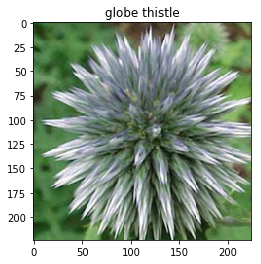

In [38]:
# show the image
imshow(image, title=img_name)

----------------------------------

## Class Prediction

Once we have images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes.

Our function will take a path to an image and a model checkpoint, then return the probabilities and classes.


In [41]:
# Prediction function
"""
Make sure to run the packages cell in the notebook beginning,
the load_model function cell, and the process_image function cell.
"""
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def predict(img_path, checkpoint, top_k, device=device):
    """
    Predict the class (or classes) of an image 
    using a trained deep learning model checkpoint.
    
    args:
        img_path (str): The image path.
        checkpoint (str): The path to a saved model checkpoint.
        top_k (int): The number of top_k classes
        device: The device used to run the code
        
    returns:
        top_classes (list): The class (or classes) of the top_k classes
        top_probs (list): The probabilities of the top_k classes
    """
    
    # loading the model
    model = load_model('my_checkpoint.pth', device)
    model = model.to(device)
    
    # image processing
    img = process_image(img_path)
    
    # converting the image numpy array to a torch tensor
    # and moving it to the device
    img = torch.from_numpy(img).type(torch.FloatTensor).to(device)
    
    # applying the model that gives...
    # log probabilities then getting the probs
    log_probs = model(img.unsqueeze_(0))
    probs = torch.exp(log_probs)
    
    # finding the topk probs and indices 
    top_probs, top_indices = probs.topk(top_k)
    
    top_probs, top_indices = top_probs[0].tolist(), top_indices[0].tolist()
    
    # rounding the top_probs
    top_probs = [round(prob, 3) for prob in top_probs]
    # converting the topk indices into classes
    # firstly, we invert the class_to_idx dict
    idx_to_class = {i:c for c, i in model.class_to_idx.items()} 
    
    # the topk classes
    top_classes = [idx_to_class[i] for i in top_indices]

    return top_classes, top_probs

#### Predicting images using the saved checkpoint (my_checkpoint.pth)

In [52]:
img_path = 'flowers/test/17/image_03830.jpg'
top_classes, top_probs = predict(img_path, 'my_checkpoint.pth', top_k=5)
print(top_classes)
top_probs

['17', '100', '71', '77', '66']


[1.0, 0.0, 0.0, 0.0, 0.0]

### Label mapping

We will also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [53]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [54]:
# converting the classes into names
    
top_names = [cat_to_name[c] for c in top_classes]
top_names  

['purple coneflower',
 'blanket flower',
 'gazania',
 'passion flower',
 'osteospermum']

------------------------------------

# Finally, a sanity checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. 

We will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.




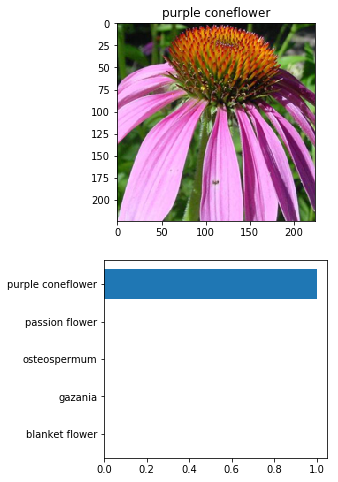

In [56]:
# Display an image along with the top 5 classes

plt.figure(figsize=[4,8])
ax = plt.subplot(2, 1, 1)

# figuring the acual image
image = process_image(img_path)
    
# setting the image name as title to the figure
img_class = img_path.split('/')[2]
img_name = cat_to_name[img_class]

imshow(image, ax, title=img_name)
    
# plotting the probabilities for topk classes 
# in a bar chart
plt.subplot(2, 1, 2)
plt.barh(top_names, top_probs)
plt.show()

## Awsome!
### The above figure shows that our model has predicted the flower class perfectly.


-------------------------------------------------

# *Thank You*